เช็ค GPU

In [2]:
! nvidia-smi

Wed Jul  1 08:03:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 0. Magic Command

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Install Library

Install Library ที่จำเป็น ในที่นี้เราจะใช้ โมดูล medical.imaging ของ [fastai2](https://www.bualabs.com/archives/4102/tutorial-fastai2-oxford-pets-dog-cat-37-class-machine-learning-deep-neural-networks-image-classification-ep-7/) 

In [4]:
# ## Colab
# ! pip install fastai2 kornia -q

# 2. Import Library

Import Library ที่จำเป็น

In [5]:
import gc

from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.metrics import *
from fastai2.vision.all import *

import kornia

import pandas as pd
from sklearn.metrics import *

In [6]:
seed=123456
set_seed(seed)

# 3. Dataset

ในเคสนี้เราจะใช้ Dataset ฟิล์ม Chest X-Ray Images (Pneumonia) จาก Kaggle 

เราจะ Mount Drive ไปยัง Google Drive ที่เก็บ Token File ไว้

In [7]:
dataset = 'paultimothymooney/chest-xray-pneumonia'

# Google Colab
config_path = Path('/content/drive')
learner_path = config_path/"My Drive"
data_path_base = Path('/content/datasets/')

path = data_path_base/dataset

from google.colab import drive

drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*ในการจะ Download ข้อมูลจาก Kaggle ต้องใช้ Token ดูวิธีได้ใน ep ก่อน*

In [8]:
# !kaggle datasets download {dataset} -p "{path}" --unzip

ls ดูว่าได้ Folder อะไรมาบ้าง

In [9]:
path.ls()

(#1) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray')]

In [10]:
(path/'chest_xray').ls()

(#5) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/val'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/test'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/__MACOSX')]

ดูข้อมูลใน Training Folder

In [11]:
(path/'chest_xray/train').ls()

(#2) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL')]

In [12]:
(path/'chest_xray/train/PNEUMONIA').ls()

(#3875) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1850_bacteria_4721.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person58_bacteria_274.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person478_bacteria_2035.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person12_bacteria_47.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1383_bacteria_3521.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person810_bacteria_2719.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person682_virus_1273.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1483_bacteria_3876.jpeg'),Path('/content/datasets/paul

In [13]:
(path/'chest_xray/train/NORMAL').ls()

(#1341) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0280-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0728-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0655-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0491-0001-0002.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0299-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0997-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0691-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0278-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0274-0001.jpeg'),Path('/content/

ใช้ฟังก์ชัน `get_image_files` ดึงไฟล์ทั้งหมดมาใส่ List ไว้ก่อน

In [14]:
items = get_image_files(path/'chest_xray/train')
items

(#5216) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1850_bacteria_4721.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person58_bacteria_274.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person478_bacteria_2035.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person12_bacteria_47.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1383_bacteria_3521.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person810_bacteria_2719.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person682_virus_1273.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1483_bacteria_3876.jpeg'),Path('/content/datasets/paul

# 4. Data

## 4.1 Image

ดูรูปภาพ

In [15]:
patient = 55

In [16]:
items[patient]

Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person562_virus_1102.jpeg')

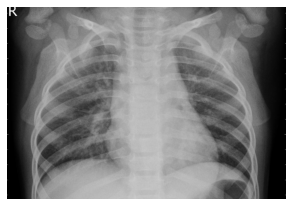

In [17]:
item = PILImage.create(items[patient])
item.show()

In [18]:
str(item)

'PILImage mode=RGB size=1152x792'

In [19]:
parent_label(items[patient])

'PNEUMONIA'

# 5. Data Pipeline

## 5.1 Exploratory Data Analysis (EDA)

สำรวจข้อมูล [Exploratory Data Analysis](https://www.bualabs.com/archives/2297/exploratory-data-analysis-eda-pandas-profiling-pandas-dataframe-pandas-ep-6/) จะเห็นว่า Class Imbalance ประมาณ 1 ต่อ 3, 1 ต่อ 1 และ 1 ต่อ 1.7

In [20]:
trn0 = get_image_files(path/'chest_xray/train/NORMAL')
trn1 = get_image_files(path/'chest_xray/train/PNEUMONIA')

val0 = get_image_files(path/'chest_xray/val/NORMAL')
val1 = get_image_files(path/'chest_xray/val/PNEUMONIA')

tst0 = get_image_files(path/'chest_xray/test/NORMAL')
tst1 = get_image_files(path/'chest_xray/test/PNEUMONIA')

trn0, trn1, val0, val1, tst0, tst1

((#1341) [Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0280-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0728-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0655-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0491-0001-0002.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0299-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0997-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0691-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0278-0001.jpeg'),Path('/content/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0274-0001.jpeg'),Path('/content

เนื่องจากใน val Folder มีแค่ class ละ 8 ไฟล์ เราจะรวม train กับ val Folder เข้าด้วยกัน แล้ว [Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) เอง 80/20

## 5.2 DataBlock

สร้าง [DataBlock](https://www.bualabs.com/archives/2693/what-is-data-pipeline-data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) และ [DataLoader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) โดยทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ตาม Default ยกเว้นการ Flip เนื่องจากฟิล์ม X-Ray ไม่มีกลับหัว และถูกถ่ายจากด้านหน้าเท่านั้น

In [21]:
class EchoingTransform(ItemTransform):
    order = 2
    split_idx = 0
    def __init__(self, e): self.e = e
    def encodes(self, x):
        img, lbl = x
        # print(img.shape)
        # print(lbl.shape)
        if self.e > 1:
            img = img.repeat(self.e, 1, 1, 1)
            lbl = lbl.repeat(self.e)
        return img, lbl

In [22]:
e = 2

In [23]:
def getDataLoaders(bs, size):
    pneumonia = DataBlock(blocks=(ImageBlock(), CategoryBlock), 
                         get_items=partial(get_image_files, folders=['train', 'val']), 
                         get_y=parent_label, 
                         splitter=RandomSplitter(), 
                         item_tfms=RandomResizedCrop(size, min_scale=0.7), 
                         batch_tfms=[EchoingTransform(e), *aug_transforms()]
                         )
    # pneumotpneumoniahorax.summary(path/'chest_xray')
    dls = pneumonia.dataloaders(path/'chest_xray', bs=bs)
    return dls    

สร้าง DataLoader ด้วย size 224 และ [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) 64 แล้วแสดงข้อมูลตัวอย่าง ใน Batch 

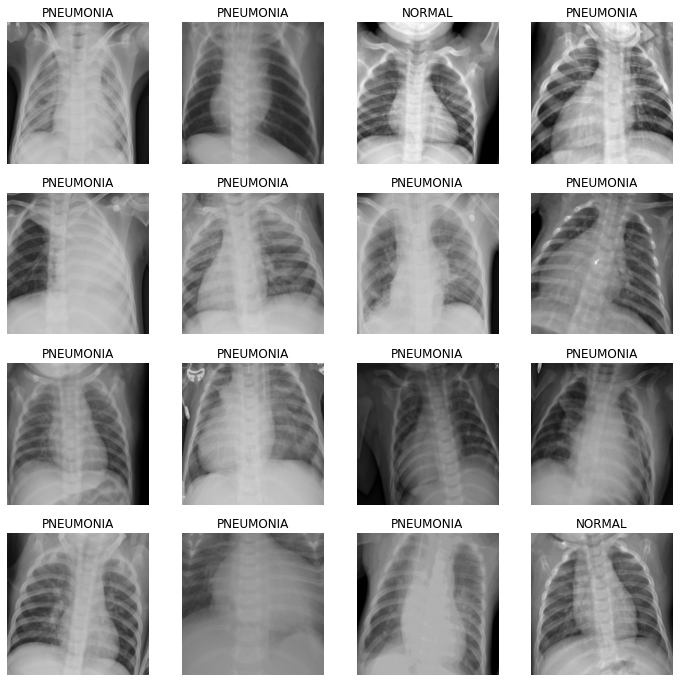

In [24]:
dls = getDataLoaders(64, 224)
dls.show_batch(max_n=16)

เช็คว่ามี 2 Class

In [25]:
dls.vocab

(#2) ['NORMAL','PNEUMONIA']

# 6. Model

เนื่องจาก Class Imbalance เราจะใช้ Weighted Cross Entropy Loss โดยให้น้ำหนักกับ Normal มากกว่า Pneumonia

In [26]:
class XFocalLoss(kornia.losses.FocalLoss):
    y_int = True
    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(XFocalLoss, self).__init__(alpha, gamma, reduction)

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:       

        # set_trace()
        # print(input.shape)
        # print(target.shape)
        return super().forward(input, target)      

    def decodes(self, x):    return x.argmax(dim=1)
    def activation(self, x): return F.softmax(x, dim=1)               

In [27]:
# weights = torch.tensor([[1.2]*1 + [0.8]]).cuda()
# loss_func = CrossEntropyLossFlat(weight=weights)

# loss_func = CrossEntropyLossFlat()

loss_func = XFocalLoss(alpha=1.0, gamma=2.0, reduction='mean')

ใช้ [Convolutional Neural Network](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) สถาปัตยกรรม [ResNet34](https://www.bualabs.com/archives/482/resnet34-vs-resnet50-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-2/) เวอร์ชันพิเศษของ fastai ชื่อว่า xresnet

In [28]:
arch = xresnet34(pretrained=False, c_in=3, act_cls=Mish, sa=True, n_out=2)

ดู Activation Function เป็น Mish แทนที่จะเป็น ReLU ตามปกติ

In [29]:
arch[0]

ConvLayer(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)

สร้าง Learner จาก [Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) ด้านบน โดยมี [Metrics](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) เช่น [Accuracy, F1 Score และ Recall](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/)

In [30]:
# learn = cnn_learner(dls, arch=arch, metrics=accuracy, 
#                     loss_func=loss_func, opt_func=ranger, 
#                     cbs=[ShowGraphCallback])

learn = Learner(dls, arch, loss_func=loss_func, opt_func=ranger, 
                cbs=[ShowGraphCallback], path=learner_path, 
                metrics=[accuracy, F1Score(axis=1), Recall(axis=1)])

# 7. Train

## 7.1 Fine-tune

เริ่มต้นเทรนตั้งแต่ต้น From Scratch ทั้งโมเดล ด้วย fit_flat_cos เนื่องจากเราใช้ [Mish Activation Function](https://www.bualabs.com/archives/4239/mish-activation-function-neural-networks-next-relu-activation-function-ep-4/)

In [31]:
# learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.090188,0.055805,0.916826,0.941176,0.925532,01:23


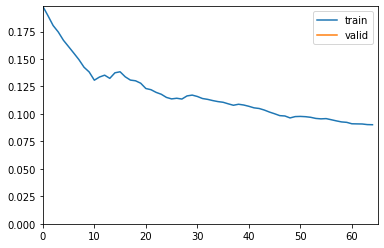

In [32]:
learn.fit_flat_cos(1, lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.059674,0.062438,0.912046,0.935844,0.892287,01:23
1,0.059237,0.261529,0.682600,0.800000,0.882979,01:22
2,0.053876,0.356027,0.619503,0.640145,0.470745,01:22
3,0.046446,0.024940,0.965583,0.976285,0.985372,01:22


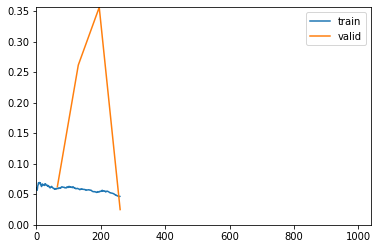

In [ ]:
learn.fit_flat_cos(16, lr=slice(3e-5, 3e-3))

ได้ F1 Score 85% เซฟโมเดลไว้ก่อน

In [ ]:
learn.save("01k_224-1")

## 7.2 Progressive Resizing

สร้าง Data Loader ใหม่ด้วย size รูป 384 x 384 Pixel และ [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) เท่ากับ 64

In [ ]:
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
bs, size = 32, 448

In [ ]:
dls = getDataLoaders(bs, size)

สร้าง [Learner](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) ใหม่จาก [Data Loader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) ด้านบน

In [ ]:
# learn = cnn_learner(dls, arch=arch, metrics=accuracy, 
#                     loss_func=loss_func, opt_func=ranger, 
#                     cbs=[ShowGraphCallback])

learn = Learner(dls, arch, loss_func=loss_func, opt_func=ranger, 
                cbs=[ShowGraphCallback], path=learner_path, 
                metrics=[accuracy, F1Score(axis=1), Recall(axis=1)])

โหลดโมเดล 224 ขึ้นมา

In [ ]:
learn.load("01k_224-1")

In [ ]:
learn.freeze()

เทรนต่อ

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_flat_cos(8, lr=slice(1e-3))

In [ ]:
learn.save("01k_384-1")

In [ ]:
# learn.load("01k_384-1");

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_flat_cos(2, lr=slice(1e-6, 1e-4))

In [ ]:
learn.save("01k_384-2")

In [ ]:
# learn.load("01k_384-2");

## 7.3 Data Augmentation Annealing

ก่อนจบ เราจะเทรนแบบไม่ใช้ Data Augmentation กันอีกสักหน่อย

In [ ]:
bs, size = 32, 448

pneumonia = DataBlock(blocks=(ImageBlock(), CategoryBlock), 
                         get_items=partial(get_image_files, folders=['train', 'val']), 
                         get_y=parent_label, 
                         splitter=RandomSplitter(valid_pct=0.1), 
                         item_tfms=RandomResizedCrop(size, min_scale=0.9), 
                         batch_tfms=[]
                         )
# pneumonia.summary(path/'chest_xray')
dls = pneumonia.dataloaders(path/'chest_xray', bs=bs)

สร้าง [Learner](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) ใหม่จาก [Data Loader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) ด้านบน

In [ ]:
# learn = cnn_learner(dls, arch=arch, metrics=accuracy, 
#                     loss_func=loss_func, opt_func=ranger, 
#                     cbs=[ShowGraphCallback])

learn = Learner(dls, arch, loss_func=loss_func, opt_func=ranger, 
                cbs=[ShowGraphCallback], path=learner_path, 
                metrics=[accuracy, F1Score(axis=1), Recall(axis=1)])

In [ ]:
learn.load("01k_384-2");
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(1, lr=slice(3e-7, 3e-5))

ได้ Accuracy 91.3%, F1 Score 81.1% และ Recall 85.1%

In [ ]:
learn.save("01k_384-3")

In [ ]:
# learn.load("01k_384-3");

แสดงผลลัพธ์การทำงาน

In [ ]:
learn.show_results(max_n=16)

# 8. ตีความผลลัพธ์

เราจะใช้ คลาส ClassificationInterpretation ในการช่วยตีความผลการทำงานของโมเดล

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

พล็อต [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/)

In [ ]:
interp.plot_confusion_matrix()

แสดงสถิติที่เกี่ยวข้อง เช่น Precision, Recall

In [ ]:
interp.print_classification_report()

แสดงรายการที่โมเดลทายผิดมากที่สุด

In [ ]:
interp.plot_top_losses(4)

# 9. Test Set

ใน Dataset นี้ นอกจาก Training Set, Validation Set แล้ว ยังมีเตรียม Test Set ไว้ให้เราด้วย เราจะใช้ข้อมูลที่แยกไว้ ใน Test Set นี้เป็นตัวทดสอบ เสมือนว่าเป็นข้อมูลจากโลกความเป็นจริง Real-world

เอารายการไฟล์ทั้งหมดมาใส่ List

In [ ]:
tst_fns = get_image_files(path/'chest_xray/test')
tst_fns

แยก Label ออกมา จาก Parent Folder

In [ ]:
tst_lbl = [parent_label(fn) for fn in tst_fns]
tst_lbl[:10], tst_lbl[-10:]

สร้าง DataLoader ใหม่จาก Transform เดิมใน Validation Set ในเคสนี้มี Label มาด้วย

In [ ]:
dl = learn.dls.test_dl(tst_fns, with_labels=True)
# dl = learn.valid_dl.new()

ลองดูข้อมูล

In [ ]:
dl.show_batch()

ใช้ Model ทำ Inference

In [ ]:
preds, _ = learn.get_preds(dl=dl)

In [ ]:
preds.shape

แปลง Label เป็น 0, 1 เพื่อใช้เปรียบเทียบ

In [ ]:
tst_lbl_num = [0 if lbl == 'NORMAL' else 1 for lbl in tst_lbl]
tst_lbl_num[:10], tst_lbl_num[-10:]

ใช้ Argmax แปลง ความน่าจะเป็นของแต่ละ class ให้เป็น 0, 1

In [ ]:
preds_num = preds.argmax(1)
preds_num[:10], preds_num[-10:]

เช็คค่า Metrics ต่าง ๆ

In [ ]:
accuracy_score(tst_lbl_num, preds_num)

In [ ]:
precision_score(tst_lbl_num, preds_num)

In [ ]:
f1_score(tst_lbl_num, preds_num)

In [ ]:
recall_score(tst_lbl_num, preds_num)

ได้ Accuracy, F1 Score, Recall ของ Test Set เท่ากับ 0.875, 0.90, 0.99 

# Credit

* https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
* https://www.bualabs.com/archives/4284/what-is-dicom-mri-x-ray-ct-scan-ultrasound-medical-diagnosis-pneumothorax-xray-dicom-image-classification-ep-9/
* https://www.bualabs.com/archives/4122/ai-diagnose-melanoma-skin-cancer-mnist-ham10000-dermatoscopic-pigmented-lesions-image-classification-ep-8/